# Data Loading

In [2]:
#Install Important Libs
%pip install -q datasets transformers pydantic matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Optional, Literal
from pydantic import BaseModel, Field

# Environment Check before running the code

In [3]:
import importlib
from typing import Optional, Literal
from pydantic import BaseModel

# --- Safe optional imports ---
if importlib.util.find_spec("torch"):
    import torch
else:
    torch = None

if importlib.util.find_spec("datasets"):
    import datasets
else:
    datasets = None

if importlib.util.find_spec("transformers"):
    import transformers
else:
    transformers = None


class LibraryVersions(BaseModel):
    torch: str = " Not Installed"
    datasets: str = " Not Installed"
    transformers: str = " Not Installed"


class GPUInfo(BaseModel):
    device: Literal["GPU", "CPU", "No Device Detected"]
    cuda_version: Optional[str] = None
    gpu_name: Optional[str] = None
    memory_gb: Optional[float] = None
    message: Optional[str] = None


class EnvironmentCheck:
    """Environment checker with Pydantic models."""

    def __init__(self) -> None:
        self.torch_version = torch.__version__ if torch else None
        self.datasets_version = datasets.__version__ if datasets else None
        self.transformers_version = transformers.__version__ if transformers else None

    def get_versions(self) -> LibraryVersions:
        """Return installed library versions as a Pydantic model."""
        return LibraryVersions(
            torch=self.torch_version or " Not Installed",
            datasets=self.datasets_version or " Not Installed",
            transformers=self.transformers_version or " Not Installed",
        )

    def check_gpu(self) -> GPUInfo:
        """Return GPU details as a Pydantic model."""
        if not torch:
            return GPUInfo(device="No Device Detected")

        if torch.cuda.is_available():
            props = torch.cuda.get_device_properties(0)
            return GPUInfo(
                device="GPU",
                cuda_version=torch.version.cuda,
                gpu_name=torch.cuda.get_device_name(0),
                memory_gb=round(props.total_memory / (1024**3), 2),
            )
        return GPUInfo(device="CPU", message="No GPU detected")


# --- Usage for manual run ---
if __name__ == "__main__":
    env = EnvironmentCheck()
    print("Library Versions:", env.get_versions().model_dump())
    print("Device Info:", env.check_gpu().model_dump())


Library Versions: {'torch': '2.8.0.dev20250319+cu128', 'datasets': '4.0.0', 'transformers': '4.56.0'}
Device Info: {'device': 'GPU', 'cuda_version': '12.8', 'gpu_name': 'NVIDIA L4', 'memory_gb': 21.95, 'message': None}


# Data Loading

In [4]:
from typing import Optional
from pydantic import BaseModel, Field
from datasets import load_dataset, DatasetDict


class DatasetConfig(BaseModel):
    """Configuration model for dataset loading."""
    dataset_name: str = Field(..., description="Name of the dataset to load (e.g., 'wikitext').")
    subset_name: str = Field(..., description="Subset/config name (e.g., 'wikitext-2-raw-v1').")


class DatasetLoader:
    """Wrapper class for loading HuggingFace datasets."""

    def __init__(self, config: DatasetConfig) -> None:
        self.config = config

    def load_data(self) -> DatasetDict:
        """Load dataset using HuggingFace."""
        dataset = load_dataset(self.config.dataset_name, self.config.subset_name)
        return dataset


config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
loader = DatasetLoader(config)
dataset = loader.load_data()

print(dataset)
for i in range(10):
    print(f"Row {i}: {dataset['train'][i]['text']!r}")



README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Row 0: ''
Row 1: ' = Valkyria Chronicles III = \n'
Row 2: ''
Row 3: ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Im

# Environment Setup and Dataset Preparation

🔹 Environment Setup

Before training a language model, we must ensure the environment is ready:

Libraries: PyTorch for neural networks, HuggingFace datasets for loading corpora, and transformers for tokenization.

GPU Availability: Training transformers on CPU is not practical. We verified CUDA version, GPU type, and VRAM size.

Reproducibility: Using a structured check (EnvironmentCheck), we can confirm dependencies and hardware setup are consistent across machines.

🔹 Dataset Preparation in LLM Training

Large-scale models are trained on diverse, massive corpora:

🌍 Common Crawl → large-scale web scrape (cleaned and deduplicated).

📚 Books → public-domain and licensed.

📝 Wikipedia → factual, well-structured text.

💻 Code → GitHub, forums, Q&A.

🧪 Research Articles → scientific sources like arXiv and PubMed.

Such datasets often reach billions to trillions of tokens. Preprocessing includes deduplication, filtering, and quality checks.

🔹 Our Choice for EduMoE

For this educational project, we use:

✅ WikiText-2 (raw):

~2M tokens — small enough for fast experiments.

Natural, factual prose similar to real-world corpora.

Already split into train, validation, and test.

Includes quirks like blank lines, which helps mimic real preprocessing challenges.

This dataset is ideal for learning the mechanics of LLM training without overwhelming compute resources.

# Tokenization

In [5]:
from typing import List
from pydantic import BaseModel, Field
from transformers import AutoTokenizer


class TokenizerConfig(BaseModel):
    """Configuration for tokenizer setup."""
    tokenizer_name: str = Field(default="gpt2", description="Pretrained tokenizer to use.")
    add_special_tokens: bool = Field(default=False, description="Whether to add special tokens like BOS/EOS.")


class TokenizerWrapper:
    """Wrapper for HuggingFace GPT-2 tokenizer."""

    def __init__(self, config: TokenizerConfig) -> None:
        self.config = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)

        # GPT-2 has no pad token by default → we assign EOS as pad for batching
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text: str) -> List[int]:
        """Convert text → token IDs."""
        return self.tokenizer.encode(text, add_special_tokens=self.config.add_special_tokens)

    def decode(self, tokens: List[int]) -> str:
        """Convert token IDs → text."""
        return self.tokenizer.decode(tokens)

    def vocab_size(self) -> int:
        """Return vocabulary size."""
        return self.tokenizer.vocab_size
        

# --- Usage ---
if __name__ == "__main__":
    config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
    tok = TokenizerWrapper(config)

    text = "EduMoE is our Mixture of Experts project."
    tokens = tok.encode(text)
    decoded = tok.decode(tokens)

    print("Vocab size:", tok.vocab_size())
    print("Text:", text)
    print("Tokens:", tokens)
    print("Decoded:", decoded)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Vocab size: 50257
Text: EduMoE is our Mixture of Experts project.
Tokens: [36, 646, 16632, 36, 318, 674, 337, 9602, 286, 36095, 1628, 13]
Decoded: EduMoE is our Mixture of Experts project.


# Tokenize WikiText-2 with Our Classes

In [6]:
# 1. Load WikiText-2 (raw)
data_config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
dataset_loader = DatasetLoader(data_config)
dataset = dataset_loader.load_data()

# 2. Load GPT-2 Byte-Level BPE tokenizer
tok_config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
tokenizer = TokenizerWrapper(tok_config)

# 3. Grab a non-empty sample from training set
sample_text = next(x["text"] for x in dataset["train"] if x["text"].strip() != "")

# 4. Encode → token IDs
token_ids = tokenizer.encode(sample_text)

# 5. Decode → back to text
decoded_text = tokenizer.decode(token_ids)

# 6. Print results
print("Original text:\n", sample_text[:200], "\n")
print("Token IDs (first 40):\n", token_ids[:40], "...\n")
print("Decoded text:\n", decoded_text[:200], "\n")
print("Char length vs Token length:", len(sample_text), "chars →", len(token_ids), "tokens")
print("Tokenizer vocab size:", tokenizer.vocab_size())


Original text:
  = Valkyria Chronicles III = 
 

Token IDs (first 40):
 [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198] ...

Decoded text:
  = Valkyria Chronicles III = 
 

Char length vs Token length: 30 chars → 9 tokens
Tokenizer vocab size: 50257


# Before implementing MOE , We will be implementing a decoder style transformer and then convert it into a MOE Type design
# This is how a gpt-2 style model looks like
![Capture](images/Capture.PNG)

# Embedding
![emblookup](images/emblookup.PNG)
![learn_para](images/learn_para.PNG)

# We will using nn.embedding as a safe wrapper for lookup table and otherwise
![nn.emb.PNG](images/nn.emb.PNG)

In [7]:
from pydantic import BaseModel, Field
import torch
import torch.nn as nn

class EmbeddingConfig(BaseModel):
    """Configuration for token embeddings."""
    vocab_size: int = Field(..., description="Number of tokens in the vocabulary")
    embedding_dim: int = Field(..., description="Dimension of each embedding vector")

class TokenEmbedding(nn.Module):
    """Embedding layer for tokens."""

    def __init__(self, config: EmbeddingConfig) -> None:
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        """
        Map token IDs to embedding vectors.
        Args:
            token_ids (Tensor): shape (batch_size, seq_len)
        Returns:
            Tensor: shape (batch_size, seq_len, embedding_dim)
        """
        return self.embedding(token_ids)




# Connecting everything till now

In [8]:
# 1. Load WikiText-2 dataset
data_config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
dataset_loader = DatasetLoader(data_config)
dataset = dataset_loader.load_data()

# 2. Load tokenizer (GPT-2 BBPE)
tok_config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
tokenizer = TokenizerWrapper(tok_config)

# 3. Get vocab size from tokenizer
vocab_size = tokenizer.vocab_size()
embedding_dim = 128   # keep small for demo, GPT-2 uses 768

# 4. Create embedding layer
embed_config = EmbeddingConfig(vocab_size=vocab_size, embedding_dim=embedding_dim)
embed_layer = TokenEmbedding(embed_config)

# 5. Take one sample from dataset (non-empty)
sample_text = next(x["text"] for x in dataset["train"] if x["text"].strip() != "")
print("Original text:", sample_text[:100], "\n")

# 6. Tokenize → IDs
token_ids = tokenizer.encode(sample_text)
token_tensor = torch.tensor([token_ids])  # add batch dim

print("Token IDs:", token_ids[:20], "...\n")

# 7. Pass through embeddings
vectors = embed_layer(token_tensor)
print("Embeddings shape:", vectors.shape)
print("First token vector (truncated):", vectors[0, 0, :10])


Original text:  = Valkyria Chronicles III = 
 

Token IDs: [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198] ...

Embeddings shape: torch.Size([1, 9, 128])
First token vector (truncated): tensor([-0.8261,  1.4604,  0.4320, -1.5230, -0.1689,  0.3946, -0.5391, -0.9762,
         1.0881, -0.4238], grad_fn=<SliceBackward0>)


# positional embeddings

# Formula
![pos_emb](images/pos_emb.PNG)

# Benifits
![pos_emb_1](images/pos_emb_1.PNG)

# the sinusoidal positional encoding (original Transformer, Vaswani et al. 2017) is not learnable.

# Lately system use somehting known Rotary Position Embeddings (RoPE)

In [10]:
import torch
import torch.nn as nn
import math
from pydantic import BaseModel, Field


class PositionalEncodingConfig(BaseModel):
    """Configuration for sinusoidal positional encoding."""
    embedding_dim: int = Field(..., description="Embedding dimension (same as token embeddings)")
    max_len: int = Field(5000, description="Maximum sequence length (context window)")


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding (Vaswani et al. 2017)."""

    def __init__(self, config: PositionalEncodingConfig) -> None:
        super().__init__()
        self.config = config
        d_model = config.embedding_dim
        max_len = config.max_len

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Position indices: (max_len, 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Different frequencies for each dimension (0,2,4,...)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as buffer → not learnable, moves with model to GPU
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor (batch_size, seq_len, embedding_dim)
        Returns:
            Tensor with positional encoding added
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [11]:
# Token embeddings first
embed_config = EmbeddingConfig(vocab_size=50257, embedding_dim=128)
embed_layer = TokenEmbedding(embed_config)

# Positional encodings
pos_config = PositionalEncodingConfig(embedding_dim=128, max_len=512)
pos_encoder = PositionalEncoding(pos_config)

# Example input: 1 sentence, 9 tokens
token_ids = torch.tensor([[796, 569, 18354, 7496, 17740, 6711, 796, 220, 198]])
token_vectors = embed_layer(token_ids)

print("Before Positional Encoding:", token_vectors[0, 0, :5])

# Add positional encodings
out = pos_encoder(token_vectors)

print("After Positional Encoding:", out[0, 0, :5])
print("Output shape:", out.shape)


Before Positional Encoding: tensor([ 0.5767,  1.2355, -1.0033, -0.4563, -0.0706], grad_fn=<SliceBackward0>)
After Positional Encoding: tensor([ 0.5767,  2.2355, -1.0033,  0.5437, -0.0706], grad_fn=<SliceBackward0>)
Output shape: torch.Size([1, 9, 128])


# Before moving towards multihead attention and other forms of attention best is to reivse a simple feed forward network

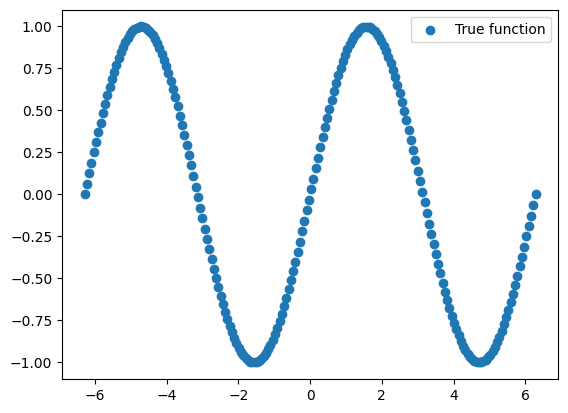

In [5]:
import torch
import matplotlib.pyplot as plt

# generate data
torch.manual_seed(42)  # reproducibility
x = torch.linspace(-2*torch.pi, 2*torch.pi, 200).unsqueeze(1)  # shape (200, 1)
y = torch.sin(x)  # target

# visualize
plt.scatter(x.numpy(), y.numpy(), label="True function")
plt.legend()
plt.show()


In [6]:
#Input layer → hidden layer (ReLU) → output layer

import torch.nn as nn

class SimpleFFN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # (1 -> 16) #Here there 16 neurons in the hidden layer
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # (16 -> 1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
# create model
model = SimpleFFN(input_dim=1, hidden_dim=16, output_dim=1)

# pick a sample x
x_sample = torch.tensor([[1.0]])  # shape (1,1)
y_pred = model(x_sample)

print("Input:", x_sample.item())
print("Model output (untrained):", y_pred.item())


Input: 1.0
Model output (untrained): 0.9520095586776733


In [8]:
#Setup Loss function and Optimizer
import torch.optim as optim

# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [9]:
# training loop
epochs = 1000
for epoch in range(epochs):
    # forward pass
    y_pred = model(x)
    
    # loss
    loss = criterion(y_pred, y)
    
    # backward pass
    optimizer.zero_grad()   # reset gradients
    loss.backward()         # compute gradients
    optimizer.step()        # update weights
    
    # log every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 100/1000, Loss: 0.2537
Epoch 200/1000, Loss: 0.1558
Epoch 300/1000, Loss: 0.1446
Epoch 400/1000, Loss: 0.1430
Epoch 500/1000, Loss: 0.1416
Epoch 600/1000, Loss: 0.1388
Epoch 700/1000, Loss: 0.1332
Epoch 800/1000, Loss: 0.1224
Epoch 900/1000, Loss: 0.1064
Epoch 1000/1000, Loss: 0.0906


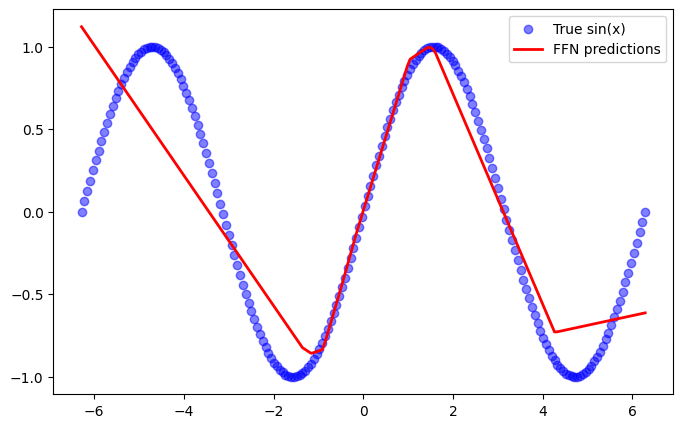

In [10]:
# model predictions after training
with torch.no_grad():  # no gradients needed
    y_pred = model(x)

# plot
plt.figure(figsize=(8,5))
plt.scatter(x.numpy(), y.numpy(), label="True sin(x)", color="blue", alpha=0.5)
plt.plot(x.numpy(), y_pred.numpy(), label="FFN predictions", color="red", linewidth=2)
plt.legend()
plt.show()


# Full Code for an FFN

Epoch 100/10000, Loss: 0.1225
Epoch 200/10000, Loss: 0.0998
Epoch 300/10000, Loss: 0.0811
Epoch 400/10000, Loss: 0.0582
Epoch 500/10000, Loss: 0.0368
Epoch 600/10000, Loss: 0.0216
Epoch 700/10000, Loss: 0.0126
Epoch 800/10000, Loss: 0.0075
Epoch 900/10000, Loss: 0.0049
Epoch 1000/10000, Loss: 0.0035
Epoch 1100/10000, Loss: 0.0024
Epoch 1200/10000, Loss: 0.0019
Epoch 1300/10000, Loss: 0.0015
Epoch 1400/10000, Loss: 0.0013
Epoch 1500/10000, Loss: 0.0012
Epoch 1600/10000, Loss: 0.0010
Epoch 1700/10000, Loss: 0.0010
Epoch 1800/10000, Loss: 0.0009
Epoch 1900/10000, Loss: 0.0009
Epoch 2000/10000, Loss: 0.0008
Epoch 2100/10000, Loss: 0.0008
Epoch 2200/10000, Loss: 0.0008
Epoch 2300/10000, Loss: 0.0007
Epoch 2400/10000, Loss: 0.0007
Epoch 2500/10000, Loss: 0.0030
Epoch 2600/10000, Loss: 0.0009
Epoch 2700/10000, Loss: 0.0008
Epoch 2800/10000, Loss: 0.0007
Epoch 2900/10000, Loss: 0.0009
Epoch 3000/10000, Loss: 0.0009
Epoch 3100/10000, Loss: 0.0008
Epoch 3200/10000, Loss: 0.0016
Epoch 3300/10000,

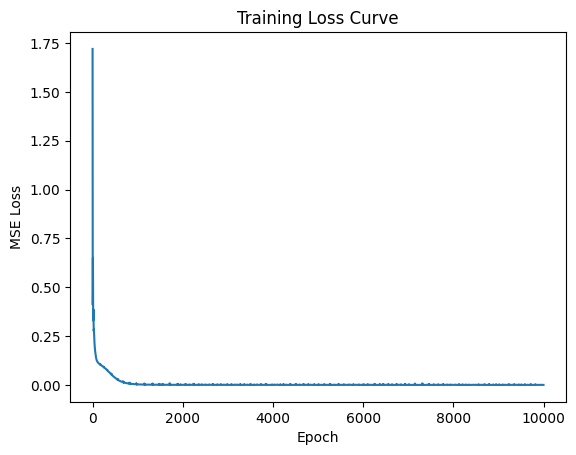

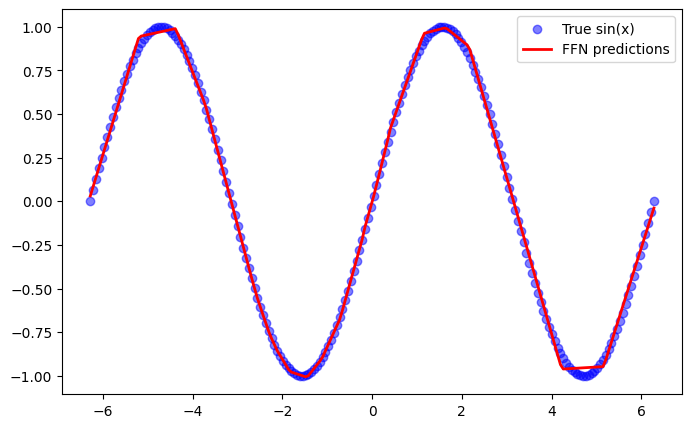

In [13]:
# ---------------------------
# Feedforward Network (FFN) Example
# Task: Learn sin(x)
# ---------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Dataset
torch.manual_seed(42)
x = torch.linspace(-2*torch.pi, 2*torch.pi, 200).unsqueeze(1)   # shape (200, 1)
y = torch.sin(x)

# 2. Define FFN
class SimpleFFN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleFFN()

# 3. Loss + Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. Training loop
epochs = 10000
losses = []

for epoch in range(epochs):
    # forward
    y_pred = model(x)
    loss = criterion(y_pred, y)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 5. Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()

# 6. Plot predictions vs true
with torch.no_grad():
    y_pred = model(x)

plt.figure(figsize=(8,5))
plt.scatter(x.numpy(), y.numpy(), label="True sin(x)", color="blue", alpha=0.5)
plt.plot(x.numpy(), y_pred.numpy(), label="FFN predictions", color="red", linewidth=2)
plt.legend()
plt.show()


# From Basic FFN to Modern FFN

The above was a **basic FFN**. Lately, things have changed a bit — the **heart is still the same**, but modern architectures add some refinements:

---

###  Step A – RMSNorm (Pre-Norm)
- Normalize the input **before** passing into the FFN.  
- Use **RMSNorm** (lighter, used in *LLaMA* / *Mistral*) instead of LayerNorm.  

---

###  Step B – SwiGLU (Modern Gating)
- Replace the plain MLP with **SwiGLU** for richer dynamics.  
- Adjust hidden dimension properly so parameter count ≈ classic 4×.  

---

### Step C – Dropout (Two Places)
- **Inside FFN** (after activation/gating).  
- **After final projection** (residual dropout).  

---

###  Step D – DropPath (Optional, Training Stabilizer)
- Randomly skip whole FFN blocks during training.  
- Helps with regularization in very deep networks.  
